In [1]:
library(tidyverse)
library(cowplot)
library(ggExtra)
library(ggbeeswarm)
library(ggrepel)

`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# 1. Load permuted AUROC distributions

In [2]:
unperm_auroc_df <- read_tsv('../../data/unpermuted_auroc_value.tsv') %>% 
    spread(feature, auroc) %>%
    mutate(prior = edge_prior) %>%
    gather('feature', 'value', -prior)

permuted_auroc_df <- read_tsv('../../data/permuted_auroc_values.tsv')

Parsed with column specification:
cols(
  feature = col_character(),
  auroc = col_double()
)
Parsed with column specification:
cols(
  adamic = col_double(),
  jaccard = col_double(),
  preferential_attachment = col_double(),
  resource_allocation = col_double(),
  rwr = col_double()
)


# 2. Plot analysis

In [3]:
dotplot_data <- bind_rows(
    unperm_auroc_df %>% mutate(permuted = F),
    permuted_auroc_df %>%
        gather('feature', 'value') %>%
        mutate(permuted = T)
) %>%
mutate(prior = first(prior)) %>%
mutate(
    feature = feature %>% recode_factor(
        edge_prior = 'Edge prior',
        preferential_attachment = 'Preferential attachment index',
        adamic = 'Adamic/Adar index',
        jaccard = 'Jaccard index',
        resource_allocation = 'Resource allocation index',
        rwr = 'Random walk with restart'),
    permuted = factor(permuted, levels = c(T, F))
) %>%
filter(feature != 'Edge prior')

In [4]:
options(repr.plot.width=7, repr.plot.height=2.5)

auroc_dotplot <- dotplot_data %>%
ggplot(aes(y = feature, x = value, color = permuted, shape = permuted)) +
geom_point(data = dotplot_data %>% filter(permuted == T), size = 3, alpha = 0.1) +
geom_point(data = dotplot_data %>% filter(permuted == F), size = 3, alpha = 0.6) +
geom_vline(aes(xintercept = prior), color = 'red', linetype = 'dashed') +
coord_cartesian(xlim = c(0.5, 1)) +
xlab('AUROC') +
theme_zietzm() +
theme(axis.title.y = element_blank(), axis.text.y = element_text(size = 12, color = 'black'),
      axis.title.x = element_text(size = 13, color = 'black'), 
      panel.grid.major = element_line(size = 0.3, color = 'grey',),
      axis.text.x = element_text(size = 12)) +
scale_color_discrete(name = 'Training network', labels = c("Unpermuted", "Permuted")) +
scale_shape(name = 'Training network', labels = c("Unpermuted", "Permuted"))

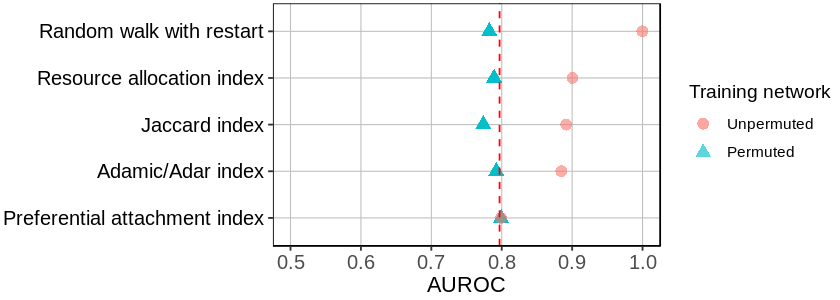

In [5]:
options(repr.plot.width=7, repr.plot.height=2.5)

ggsave(filename = '../../img/feature-auroc.png', auroc_dotplot, width = 7, height = 2.5, dpi = 300)

auroc_dotplot